In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import seasonal_esd_anomaly_detection.seasonal_esd as sesd
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

In [57]:
bls_fy_complete = pd.read_csv('data/bls_fy_2014_2018.csv', index_col=['allotment_date'], parse_dates=['allotment_date'])
bls_fy16_complete = pd.read_csv('data/bls_fy16.csv', index_col=['allotment_date'], parse_dates=['allotment_date'])

In [58]:
bls_fy16_complete = bls_fy16_complete.sort_index()
bls_fy16_complete['total_expenditure'] = bls_fy16_complete['expenditure'] + bls_fy16_complete['surrender_withdrwal']
bls_fy16_alloted_amount = bls_fy16_complete[['alloted_amount']]
bls_fy16_expenditure = bls_fy16_complete[['expenditure']]
bls_fy16_total_expenditure = bls_fy16_complete[['total_expenditure']]
bls_fy16_balance = bls_fy16_complete[['balance']]


bls_fy_complete = bls_fy_complete.sort_index()
bls_fy_complete['total_expenditure'] = bls_fy_complete['expenditure'] + bls_fy_complete['surrender_withdrwal']
bls_fy_alloted_amount = bls_fy_complete[['alloted_amount']]
bls_fy_expenditure = bls_fy_complete[['expenditure']]
bls_fy_total_expenditure = bls_fy_complete[['total_expenditure']]
bls_fy_balance = bls_fy_complete[['balance']]

In [65]:
bls_fy_complete.loc["2017-04-01":"2017-06-30"]

,ddo_code,ddo_name,budget_code,allotment_serial_no,allotment_id,alloted_amount,expenditure,surrender_withdrwal,deduct_amount,balance,total_expenditure
allotment_date,,,,,,,,,,,
2017-04-01,BLSFOR001,Conservator of Forests & Working Plans Officer...,22-2406-01-005-0484-01003-136-11-1-0,1,25,1494000,1494000,0,0,0,1494000
2017-04-01,BLSFOR001,Conservator of Forests & Working Plans Officer...,22-2406-01-005-0484-01003-136-11-1-0,1,27,108000,108000,0,0,0,108000
2017-04-01,BLSFOR001,Conservator of Forests & Working Plans Officer...,22-2406-01-005-0484-01003-136-11-1-0,1,28,10000,10000,0,0,0,10000
2017-04-01,BLSFOR001,Conservator of Forests & Working Plans Officer...,22-2406-01-005-0484-01003-136-11-1-0,1,29,9000,9000,0,0,0,9000
2017-04-01,BLSFOR001,Conservator of Forests & Working Plans Officer...,22-2406-01-005-0484-01003-156-11-1-0,1,26,1782000,1533483,0,0,248517,1533483
2017-04-02,BLSHOM008,Superintendent of Police Balasore,01-2055-00-109-0321-09001-000-11-1-0,4,44,17000,17000,0,0,0,17000
2017-04-02,BLSHOM008,Superintendent of Police Balasore,01-2055-00-109-0321-09001-000-11-1-0,2,35,742000,329089,402811,0,10100,731900
2017-04-02,BLSHOM008,Superintendent of Police Balasore,01-2055-00-109-0321-09001-000-11-1-0,1,34,648000,583294,0,0,64706,583294
2017-04-02,BLSHOM008,Superintendent of Police Balasore,01-2055-00-109-0321-09001-000-11-1-0,2,50,932000,824754,103098,0,4148,927852


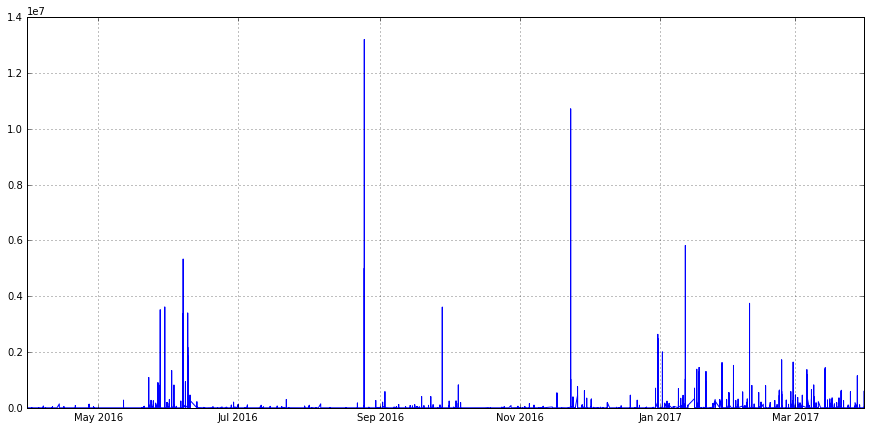

In [66]:
plt.figure(figsize=(15, 7))
plt.plot(bls_fy16_balance)
plt.grid(True)
plt.show()

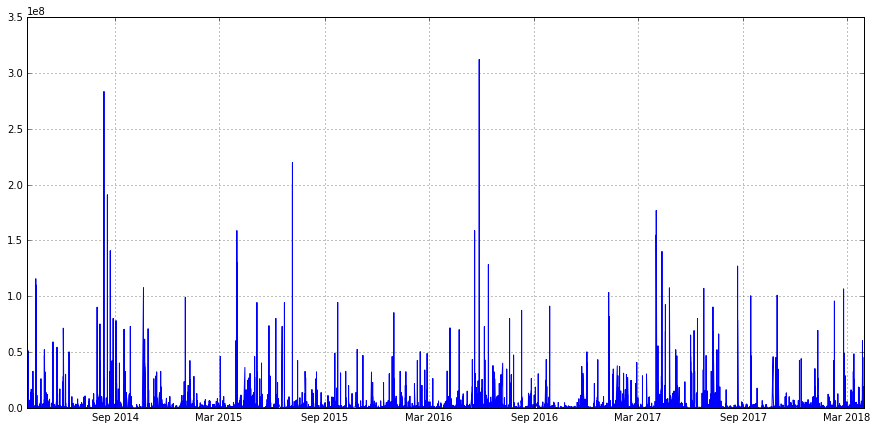

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(bls_fy16_total_expenditure)
plt.grid(True)
plt.show()

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [24]:
moving_average(bls_fy16_expenditure, 30)

1604894.9333333333

In [28]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,10))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            anomalies = anomalies.dropna(subset=[anomalies.columns[0]]) #TODO: Drop NaNs
            anomalies = anomalies[(anomalies.T != 0).any()] #TODO: Zero Removes logic needs to be revisted
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    #return anomalies

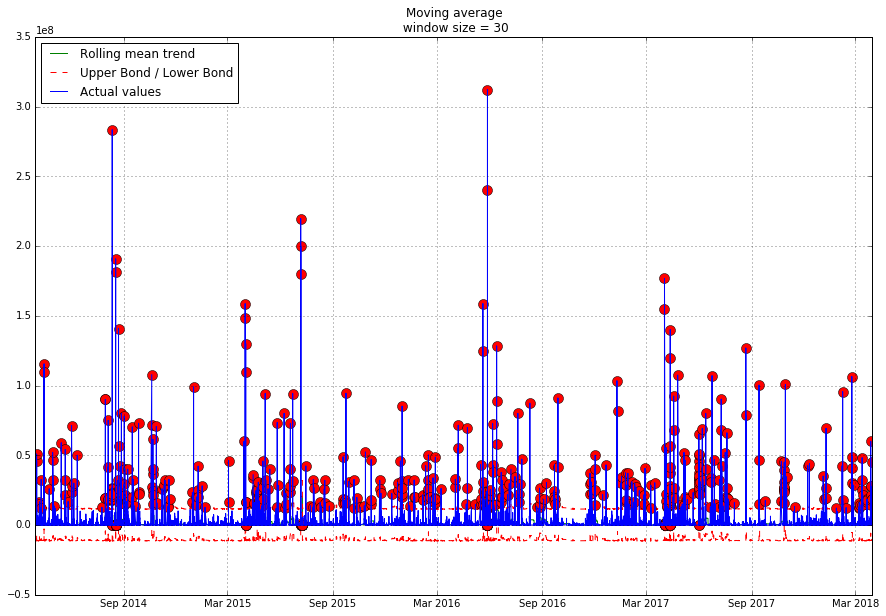

In [29]:
plot_moving_average(bls_fy16_total_expenditure, 30, plot_intervals=True, plot_anomalies=True)

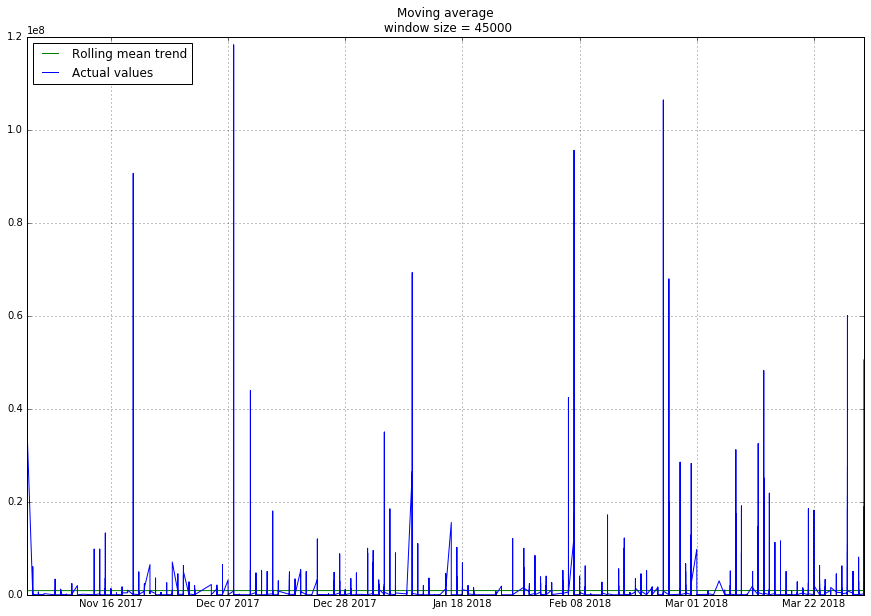

In [44]:
plot_moving_average(bls_fy16_alloted_amount, 45000)

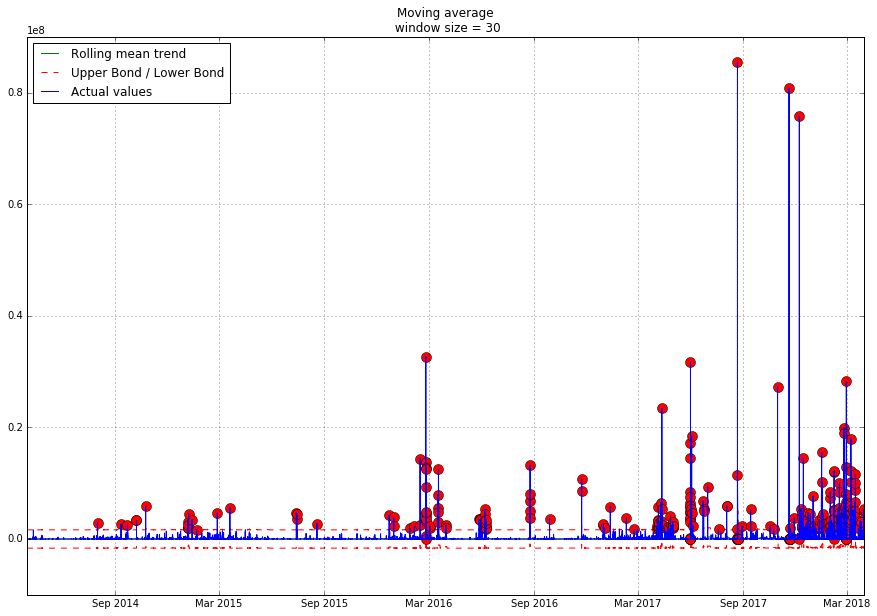

In [40]:
balance_anomalies = plot_moving_average(bls_fy16_balance, 30, plot_intervals=True, plot_anomalies=True)

In [19]:
balance_anomalies.dropna(subset=[balance_anomalies.columns[0]])

,balance
allotment_date,
2014-08-01,2.93172e+06
2014-09-11,2.655e+06
2014-09-22,2.5314e+06
2014-10-08,3.35995e+06
2014-10-08,3.35063e+06
2014-10-24,5.83834e+06
2015-01-06,3.11523e+06
2015-01-06,1.88205e+06
2015-01-06,2.0303e+06


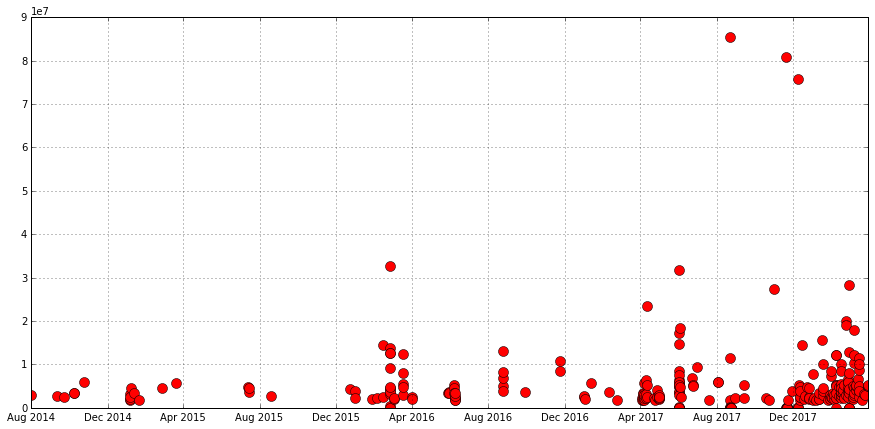

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(balance_anomalies, "ro", markersize=10)
plt.grid(True)
plt.show()

In [45]:
def weighted_average(series, weights):
    """
        Calculate weighted average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [46]:
weighted_average(bls_fy16_total_expenditure, [0.6, 0.3, 0.1])

98782.5

In [47]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);


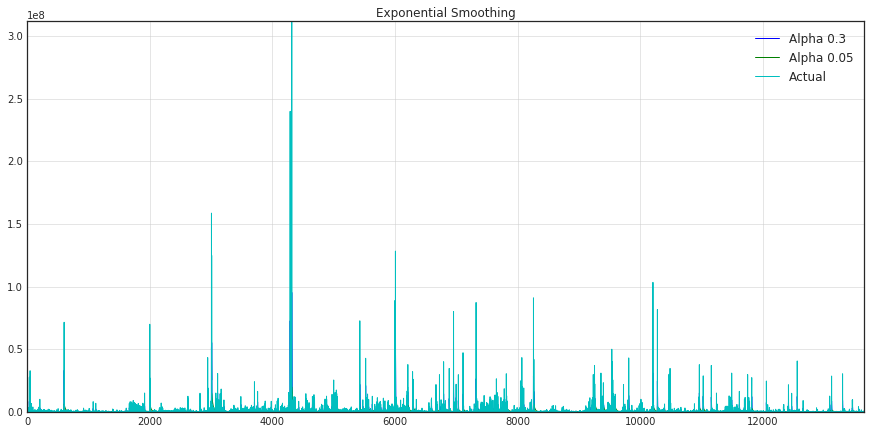

In [59]:
plotExponentialSmoothing(bls_fy16_total_expenditure.total_expenditure, [0.3, 0.05])

In [55]:

def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

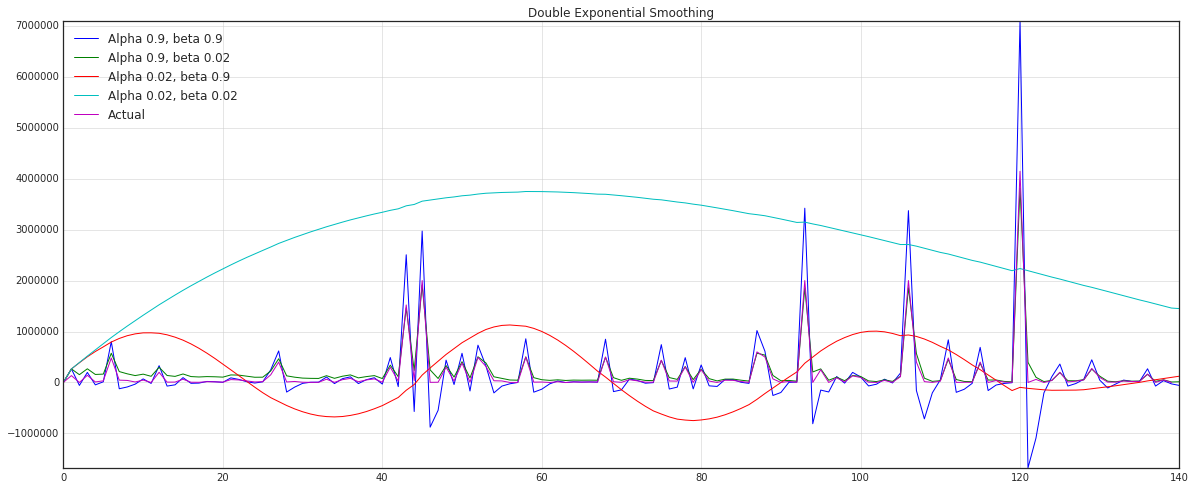

In [79]:
plotDoubleExponentialSmoothing(bls_fy16_total_expenditure.loc["2017-01-01":"2017-01-7"].total_expenditure, alphas=[0.9, 0.02], betas=[0.9, 0.02])